In [1]:
import os
from os.path import dirname, abspath, join

import sys
import seaborn as sns
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms


from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

In [2]:
# Load local libraries
# ROOT contais the project directory 
os.chdir(dirname(os.getcwd()))
os.getcwd()

'/home/ubuntu/master_thesis'

In [3]:
# Import local libraries
from src.logger import set_logger as sl

# Load transformations
from src.dataset import FundusDataset
from src.RAMdatset import FundusDatasetRAM
from src.plot_images import plot_images
from src.predict import predict

In [4]:
# Set-up logger
try:
    if logger is None:
        logger = sl("info")
except:
    logger = sl("info")

In [5]:
# Put data
batch_size    = 256
num_workers   = os.cpu_count()

im_size       = (300, 300)

data          = abspath('/mnt/data/ukbb_300x300_normalized/')
target_test   = abspath('./data/ukbb_metadata_qc_test.csv')
model_pth     = abspath('./output/models/ukbb-sex-nor-300x300_iv3-bs256-lr001.pth_best.pth')

device        = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
######################################################################################
# Initial report
logger.info(f"System Python version  = {sys.version}")
logger.info(f"System Pytorch version = {torch.__version__}")
logger.info(f"System usable CPUs     = {os.cpu_count()}")

# Device setting and CUDA report 
logger.info(f"System training device = {device}")
if  torch.cuda.is_available():
    logger.info(f"System CUDA version    = {torch.version.cuda}")
    logger.info(f"System CUDA count      = {torch.cuda.device_count()}")
    logger.info(f"System CUDA name       = {torch.cuda.get_device_name()}")
    
# Load train and validation dataset
logger.info(f"Path working directory = {os.getcwd()}")
logger.info(f"Path input data        = {data}")
logger.info(f"Path to target train   = {target_test}")
logger.info(f"Path model             = {model_pth}")

2021-03-29 09:44:01,797 - INFO - System Python version  = 3.7.10 (default, Feb 26 2021, 18:47:35) 
[GCC 7.3.0]
2021-03-29 09:44:01,798 - INFO - System Pytorch version = 1.8.0
2021-03-29 09:44:01,799 - INFO - System usable CPUs     = 96
2021-03-29 09:44:01,800 - INFO - System training device = cuda:0
2021-03-29 09:44:01,800 - INFO - System CUDA version    = 11.1
2021-03-29 09:44:01,801 - INFO - System CUDA count      = 8
2021-03-29 09:44:01,813 - INFO - System CUDA name       = Tesla T4
2021-03-29 09:44:01,814 - INFO - Path working directory = /home/ubuntu/master_thesis
2021-03-29 09:44:01,814 - INFO - Path input data        = /mnt/data/ukbb_300x300_normalized
2021-03-29 09:44:01,815 - INFO - Path to target train   = /home/ubuntu/master_thesis/data/ukbb_metadata_qc_test.csv
2021-03-29 09:44:01,815 - INFO - Path model             = /home/ubuntu/master_thesis/output/models/ukbb-sex-nor-300x300_iv3-bs256-lr001.pth_best.pth


In [7]:
# Load dataset
logger.info(f"Loading dataset")
dataset = FundusDatasetRAM(imgs_dir=data, target_file=target_test, target="sex", augment=False)

# Get size
# Get the size of the datsets train and valid(ation)
size = len(dataset)
logger.info(f"Dataset size test       = {size}")
logger.info(f"Dataset labels/classes  = {dataset.classes}")

2021-03-29 09:44:01,821 - INFO - Loading dataset
2021-03-29 09:44:22,385 - INFO - Dataset size test       = 10910
2021-03-29 09:44:22,387 - INFO - Dataset labels/classes  = ['female', 'male']


In [8]:
# Dataloader for train and valid(ation)
logger.info(f"Setting dataloader")
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False,  num_workers=num_workers)#, pin_memory=True)

2021-03-29 09:44:22,393 - INFO - Setting dataloader


In [9]:
# Load model
model = models.inception_v3(pretrained=False, aux_logits=False)

# Get number of features in the model
n_ftrs = model.fc.in_features
logger.info(f"Model number of features = {n_ftrs}")

# Add linear layer to the data
model.fc = nn.Linear(n_ftrs, len(dataset.classes))

######################################################################################
# Send model to device, 
# if CUDA count is greater than 1 use multiple GPUs
model = model.to(device)
usable_devices =list(range(torch.cuda.device_count()))
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model, device_ids=usable_devices, output_device=device)
    logger.info(f"Let's use {torch.cuda.device_count()} GPUs!")

# Load state saved model
model.load_state_dict(torch.load(model_pth, map_location=device), strict=False)

# Set the model to evaluation only
model.eval()
logger.info(f"All good")

2021-03-29 09:44:24,145 - INFO - Model number of features = 2048
2021-03-29 09:44:26,394 - INFO - Let's use 8 GPUs!
2021-03-29 09:44:26,519 - INFO - All good


In [10]:
# Predictions
trues, predictions, probabilities = predict(model, dataloader, device)

/home/ubuntu/master_thesis/src/predict.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob = sm(outputs)


In [11]:
# Get accuracy
accuracy_score(trues, predictions)

0.8289642529789184

In [12]:
# Get the probability of the predictions
reshaped_probs = np.reshape(probabilities, (len(trues),2))

In [13]:
roc_auc_score(trues, reshaped_probs[:,1])

0.9097405599147046

In [14]:
fpr, tpr, _ = roc_curve(trues, reshaped_probs[:,1])
roc_auc = auc(fpr, tpr)
print(roc_auc)

0.9097405599147046


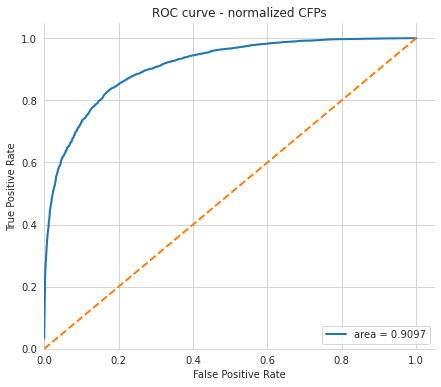

In [17]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(1,1,figsize=(7, 6))

lw = 2
sns.lineplot(x=fpr, y=tpr, lw=lw, label=f'area = {roc_auc:.4f}', ax=ax)
sns.lineplot(x=[0, 1], y=[0, 1], lw=lw, linestyle='--', ax=ax)
sns.despine(left=True)

plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve - normalized CFPs')
plt.legend(loc="lower right")
plt.show()
fig.savefig(f"./out/figures/auc-nor-bs256-001000.png")
fig.savefig(f"./out/figures/auc-nor-bs256-001000.svg")